In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# fname = '/nvme/proj/RTDP/2024.05.17.CLAS12/files/CLAS12_ECAL_PCAL_DC_2024-05-16_09-07-18.csv' #  5nA, 220.0GB
# fname = '/nvme/proj/RTDP/2024.05.17.CLAS12/files/CLAS12_ECAL_PCAL_DC_2024-05-16_09-27-14.csv' #  70nA, 474.0GB
fname = './Desktop/CLAS12_ECAL_PCAL_DC_2024-05-16_09-07-18.pcap_split/CSVFiles/CLAS12_ECAL_PCAL_DC_2024-05-16_09-07-18.csv' #  25nA, 235.0GB


print(f"Reading input file: {fname}")
# df = pd.read_csv('CLAS12_ECAL_PCAL_DC_2024-05-16_09-07-18.csv') 
df = pd.read_csv(fname)  #  5nA, 220.0GB

# Time difference between first and last packet
d_total = len(df)*1.5E-3  # in MB
t_total = df['Timestamp'].max() - df['Timestamp'].min()

# Caluculate values based on port
df1 = {}
t_total1 = {}
for port in range(7001, 7025):
    print(f"Processing port: {port}")
    df1[port] = df[df['DestinationPort'] == port].copy()
    df1[port]['time_diff'] = df1[port]['Timestamp'].diff()*1E3 # Time difference between subsequent packets in milliseconds
    df1[port] = df1[port].dropna()
    t_total1[port] = df1[port]['Timestamp'].max() - df1[port]['Timestamp'].min()

print(f'Number of packets: {len(df)} (or about {len(df)/4.0E6:.2f}M packets per stream)')
print(f'Total time for run: {t_total:.2f}s (={t_total/60.0:.2f}mins)')
print(f'Total data (approx.): {d_total*1.0E-3:.2f}GB')
print(f'Total rate (approx.): {d_total/t_total:.2f}MB/s')
for port in range(7001, 7025):
    print(f'  port {port}: {len(df1[port])} packets (or about {len(df1[port])*1.5E-3/t_total1[port]:.2f}MB/s)')

Reading input file: ./Desktop/CLAS12_ECAL_PCAL_DC_2024-05-16_09-07-18.pcap_split/CSVFiles/CLAS12_ECAL_PCAL_DC_2024-05-16_09-07-18.csv
Processing port: 7001
Processing port: 7002
Processing port: 7003
Processing port: 7004
Processing port: 7005
Processing port: 7006
Processing port: 7007
Processing port: 7008
Processing port: 7009
Processing port: 7010
Processing port: 7011
Processing port: 7012
Processing port: 7013
Processing port: 7014
Processing port: 7015
Processing port: 7016
Processing port: 7017
Processing port: 7018
Processing port: 7019
Processing port: 7020
Processing port: 7021
Processing port: 7022
Processing port: 7023
Processing port: 7024
Number of packets: 94006600 (or about 23.50M packets per stream)
Total time for run: 704.93s (=11.75mins)
Total data (approx.): 141.01GB
Total rate (approx.): 200.03MB/s
  port 7001: 2092042 packets (or about 4.55MB/s)
  port 7002: 2176372 packets (or about 4.74MB/s)
  port 7003: 5714306 packets (or about 12.44MB/s)
  port 7004: 3350381

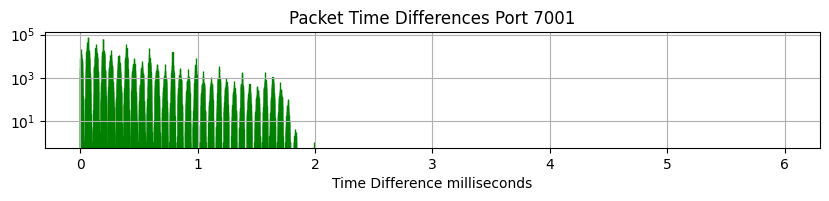

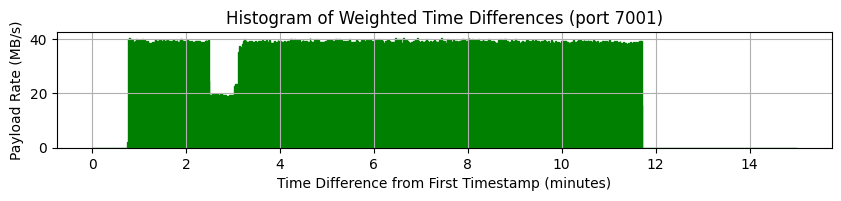

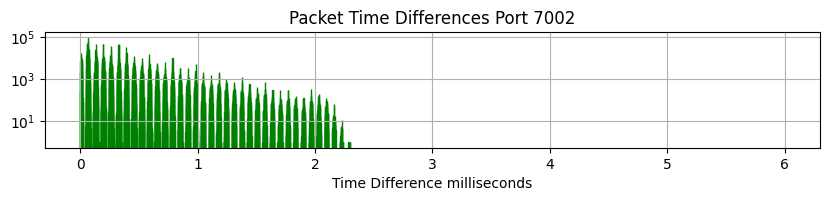

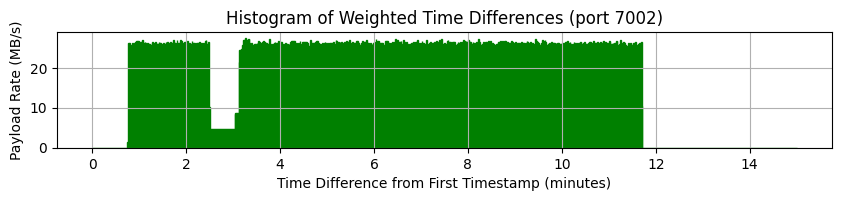

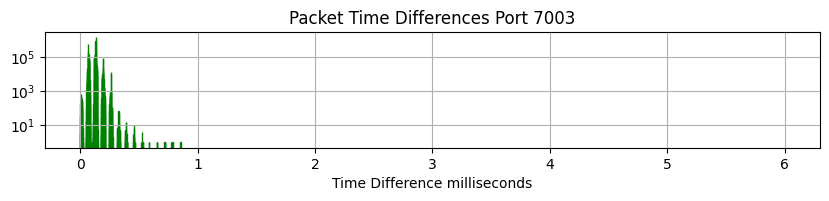

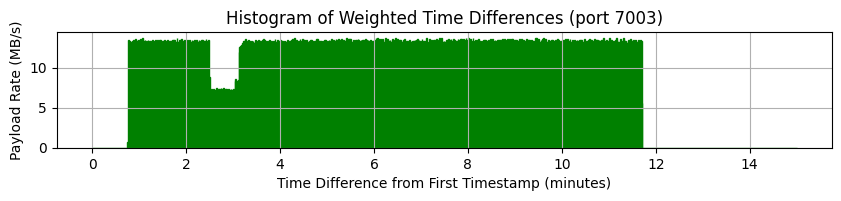

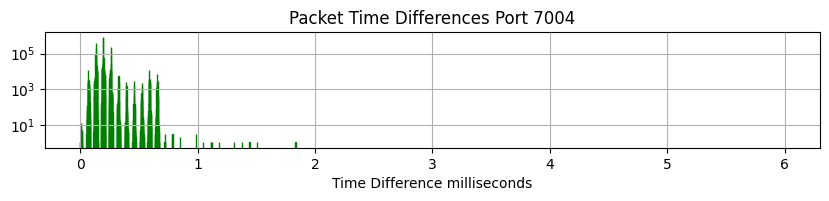

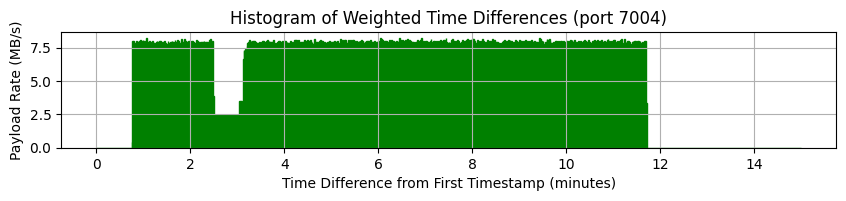

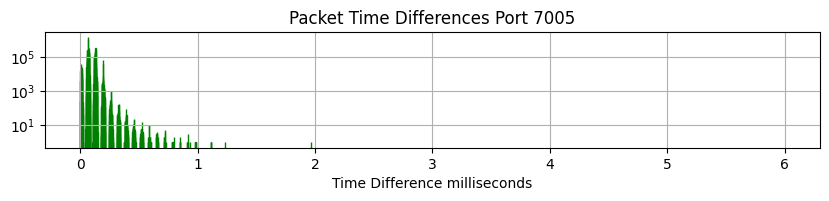

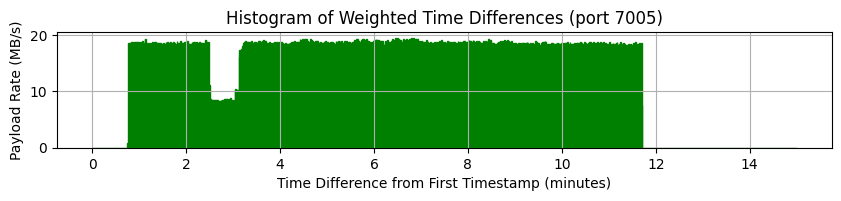

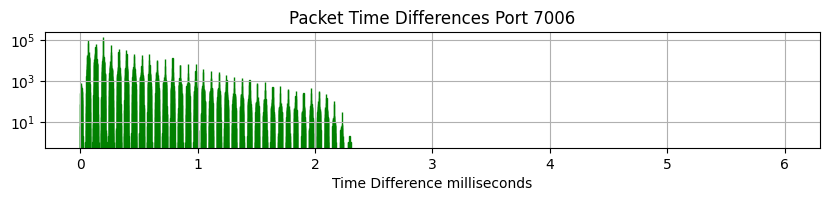

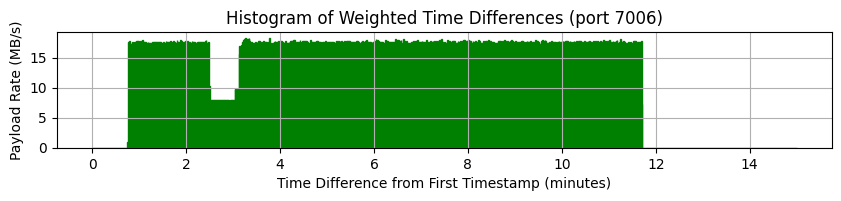

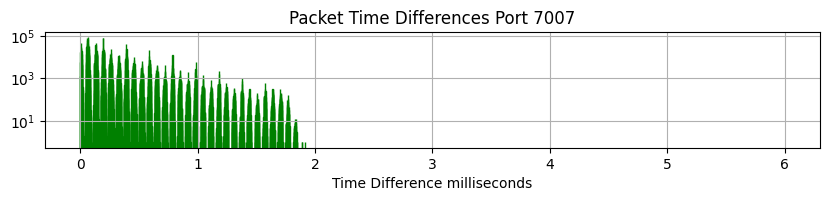

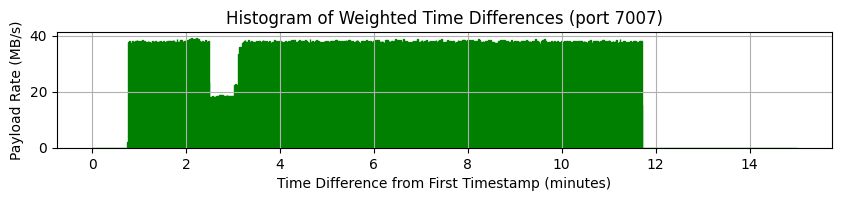

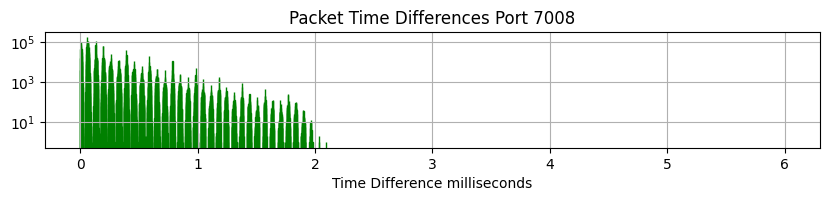

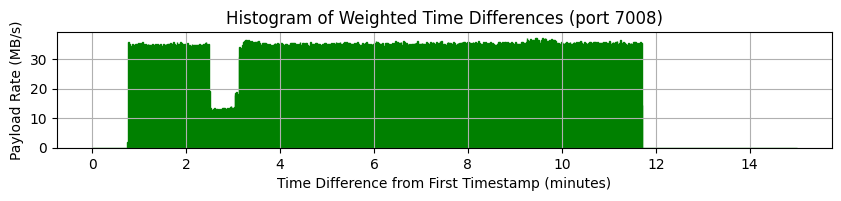

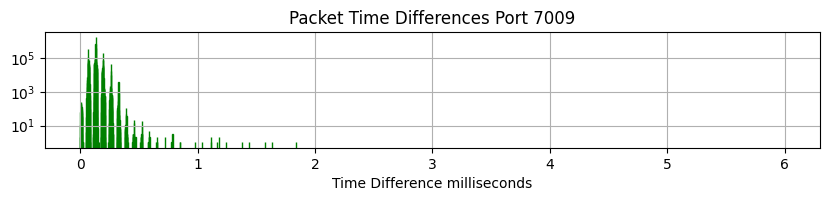

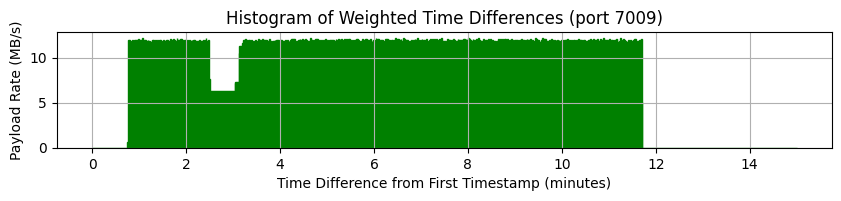

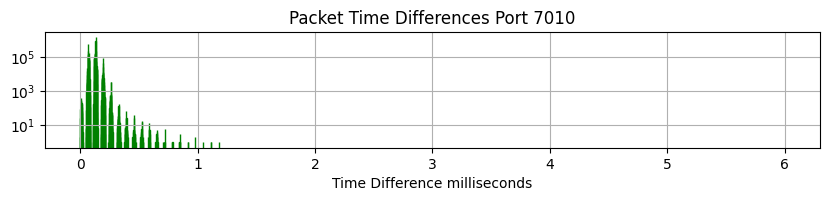

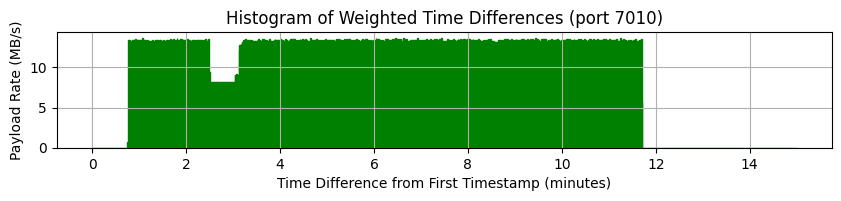

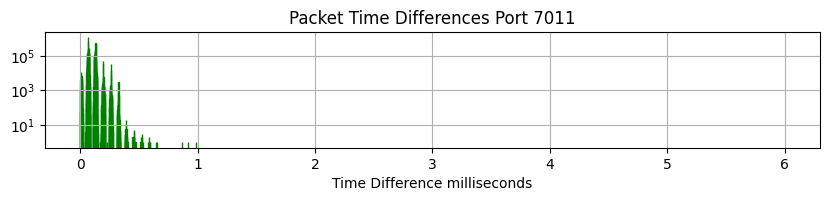

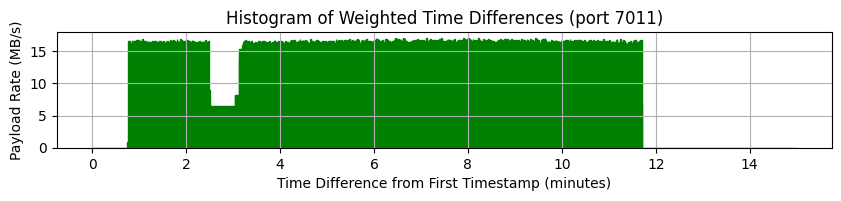

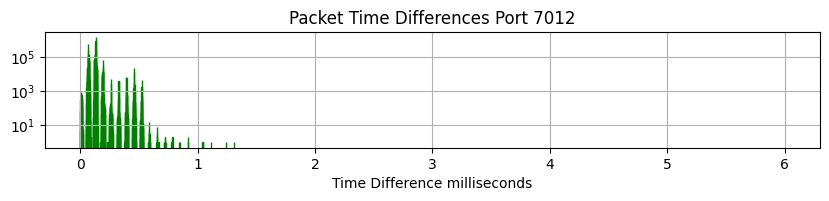

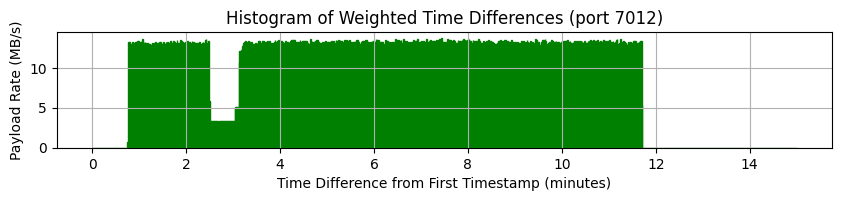

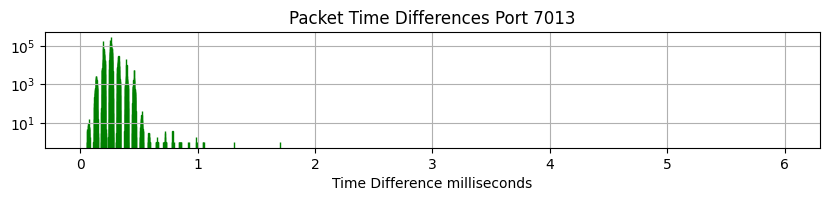

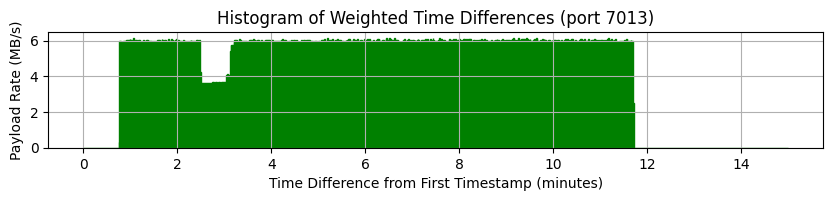

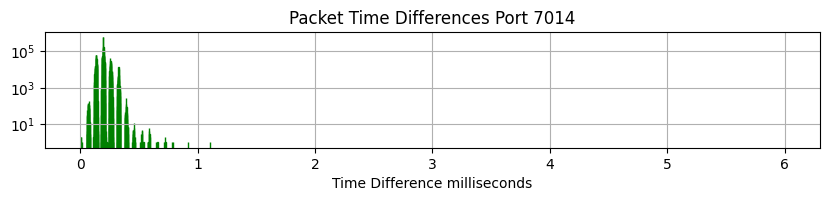

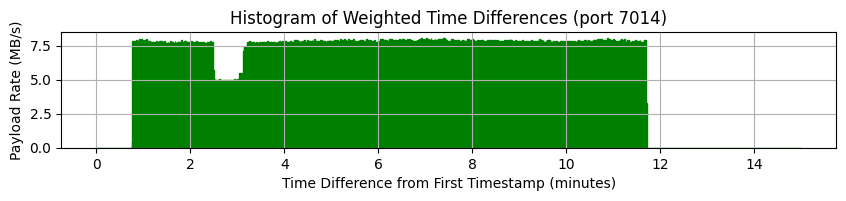

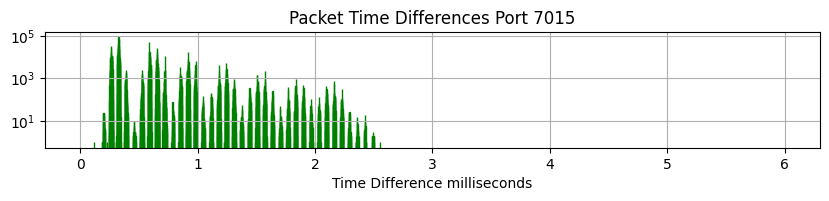

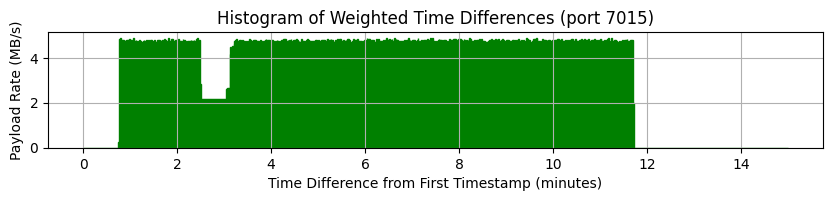

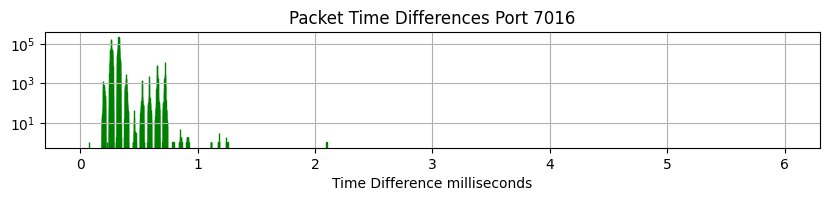

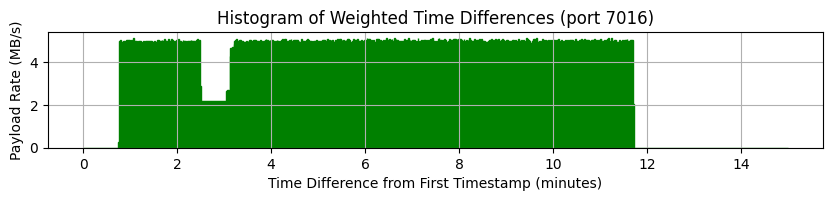

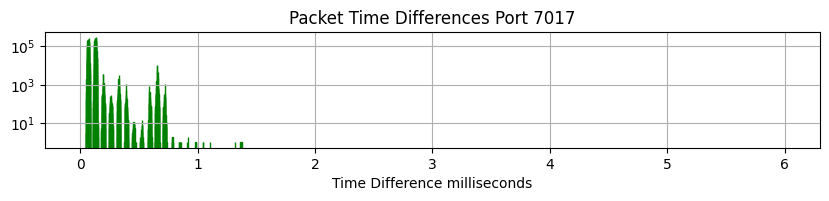

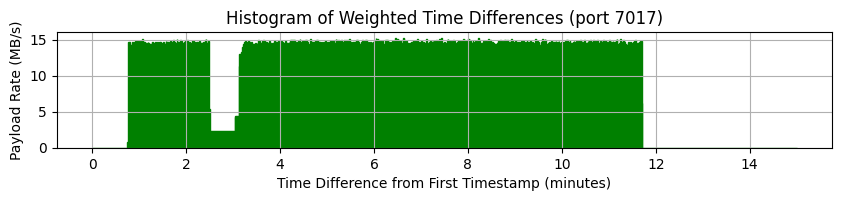

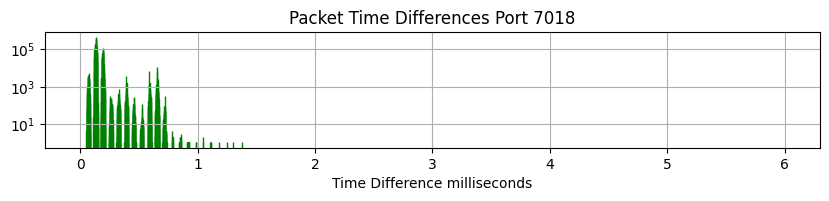

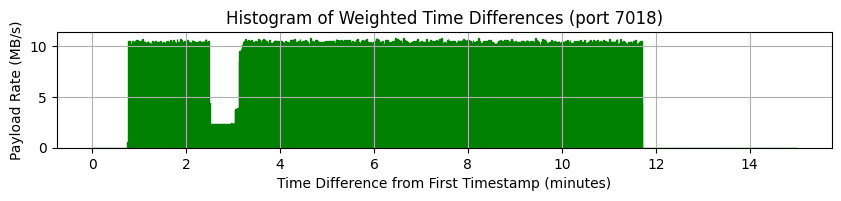

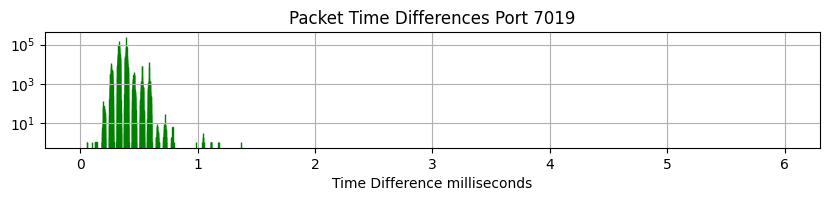

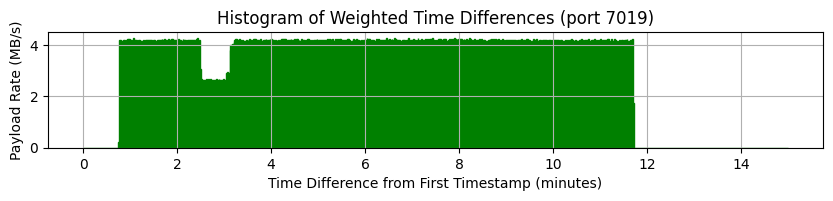

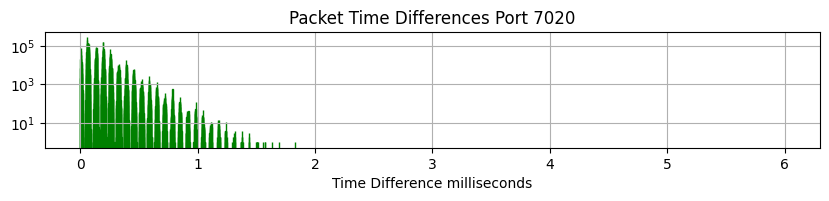

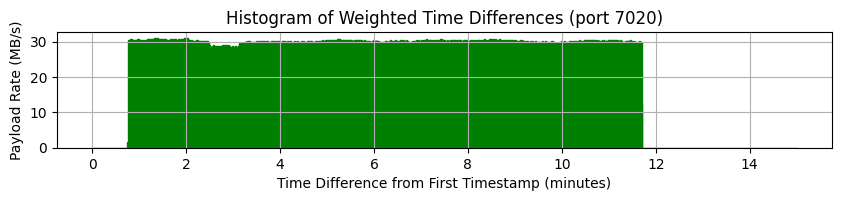

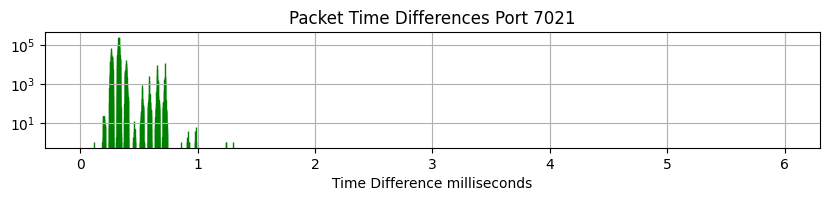

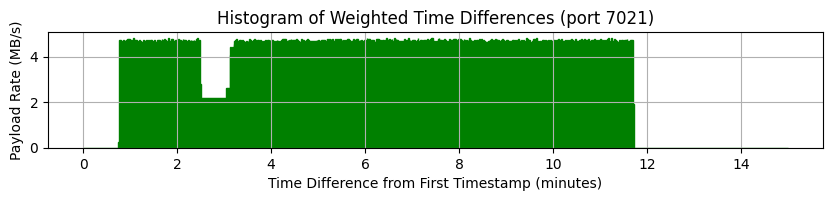

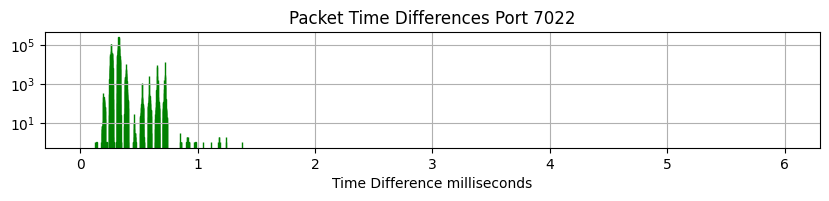

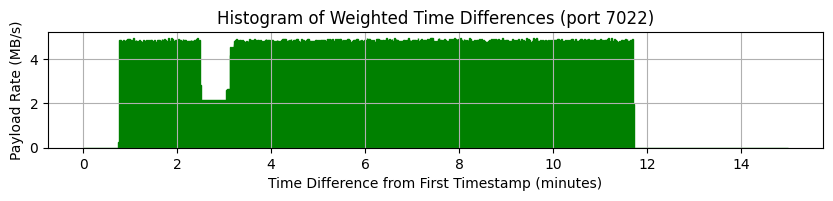

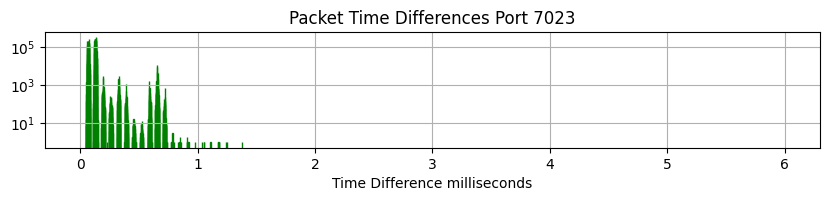

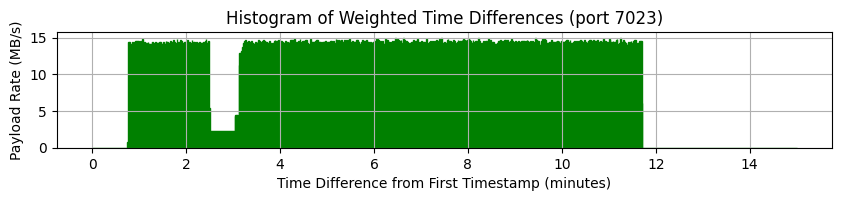

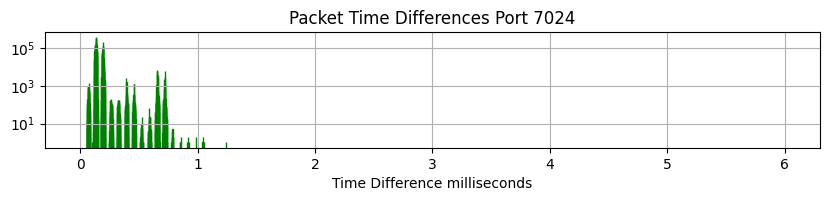

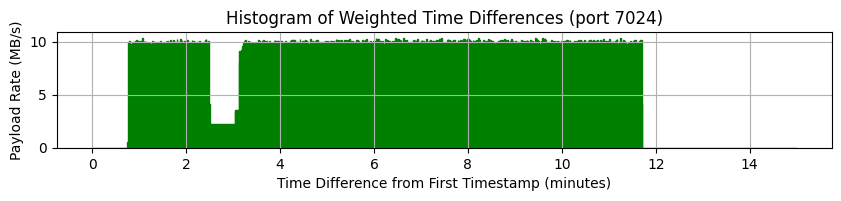

In [26]:
time_diffs = {}
average_within_subrange = {}

ports = [port for port in range(7001,7025)]

for port in ports:
    # Define histogram parameters
    bin_width = 1  # seconds
    total_range = 15 * 60  # 15 minutes in seconds
    bins = int(total_range / bin_width)

    # Create the histograms
    plt.figure(figsize=(10, 1.5))
    plt.hist(df1[port]['time_diff'], bins=5000, edgecolor='green', range=[0.0, 6.0E0], log=True)
    plt.title(f'Packet Time Differences Port {port}')
    plt.xlabel('Time Difference milliseconds')
    plt.grid()
    plt.show()

    # Calculate time differences from the first row's Timestamp (in minutes)
    time_diffs[port] = (df1[port]['Timestamp'] - df['Timestamp'].iloc[0])/60.0
    
    # Create the weighted histograms
    plt.figure(figsize=(10, 1.5))
    counts, bins, patches = plt.hist(time_diffs[port], bins=bins, range=[0.0, 15.0], weights=df1[port]['CaptureLength'] / 1.0E6, edgecolor='green')
    plt.title(f'Histogram of Weighted Time Differences (port {port})')
    plt.xlabel('Time Difference from First Timestamp (minutes)')
    plt.ylabel('Payload Rate (MB/s)')
    plt.grid()
    plt.show()

    subrange_start = 4
    subrange_end = 10

    total_sum = 0
    total_count = 0
    for count, bin_edge in zip(counts, bins[:-1]):
        bin_center = (bin_edge + bins[bins.searchsorted(bin_edge) + 1]) / 2
        if subrange_start <= bin_center <= subrange_end:
            total_sum += count
            total_count += 1

    average_within_subrange[port] = total_sum / total_count if total_count > 0 else 0



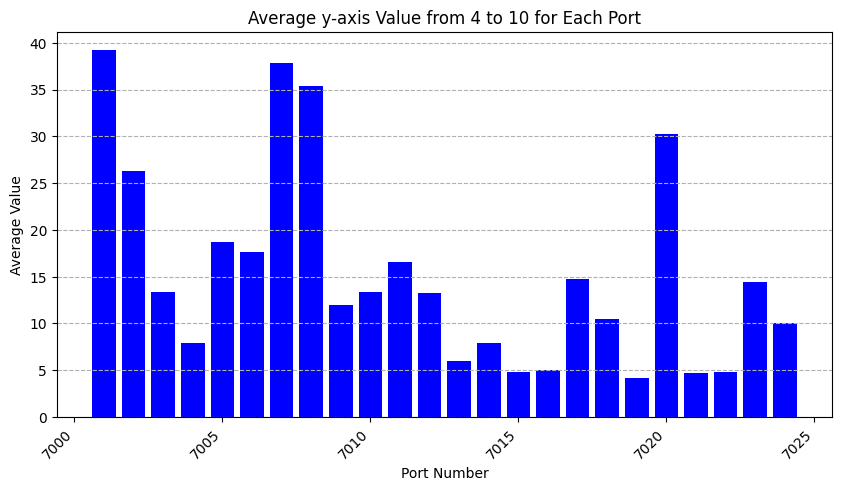

AttributeError: 'int' object has no attribute 'get_x'

In [29]:
# Print the average y-axis values within the subrange (4 to 10) for each port
ports = list(average_within_subrange.keys())
averages = list(average_within_subrange.values())

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(ports, averages, color='blue')
plt.title('Average y-axis Value from 4 to 10 for Each Port')
plt.xlabel('Port Number')
plt.ylabel('Average Value')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.show()

for bar, value in zip(ports, averages):
    plt.text(bar.get_x() + bar.get_width() / 2, value + 0.1, f'{value:.2f}', ha='center', va='bottom')

plt.show()